### Understanding and dissecting Chowdhary and Assisi, 2019

#### To-do list

1. Two reciprocally coupled **excitatory** oscillators
	- (to observe synchrony)
2. Two reciprocally coupled **inhibitory** oscillators
	- (to observe asynchrony)
3. Bipartite networks
	1. No within-group connections
	2. Complementary edges are excitatory connections
	3. Ratio of cumulative strength of excitation/inhibition is varied
4. Balanced sudoku network

#### Imports

In [1]:
from brian2 import *

INFO       Cache size for target 'cython': 1423024888 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the 'C:\Users\admin\.cython\brian_extensions' directory. [brian2]


In [2]:
%matplotlib inline

#### Two reciprocally coupled excitatory oscillators

In [130]:
tau = 4*ms

I = 1.1/ms
gamma = 1/ms

tp = tau/ms
curr = I*ms
g = gamma*ms
out = curr/g

# equation (1)
eqs = '''
dv/dt = I - gamma*v : 1
'''

# equation (2) but with t replaced by (phi*tau/gamma) [para equation]
# converted to D.E. by differentiation
# dv/dt = (I/gamma) - v is the actual equation, but tau is introduced to keep the equation dimensionally consistent.
eqs2 = '''
dv/dt = ((I/gamma) - v)/tau : 1
'''


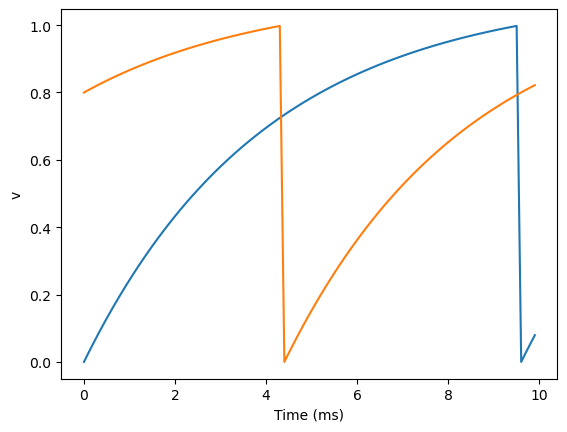

In [4]:
# Sample first spikes

start_scope()

G1 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')
G2 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')

G2.v = [0.8]

M1 = StateMonitor(G1, 'v', record=True)
M2 = StateMonitor(G2, 'v', record=True)

run(10*ms)

plot(M1.t/ms, M1.v[0], label='Neuron 1')
plot(M2.t/ms, M2.v[0], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v');

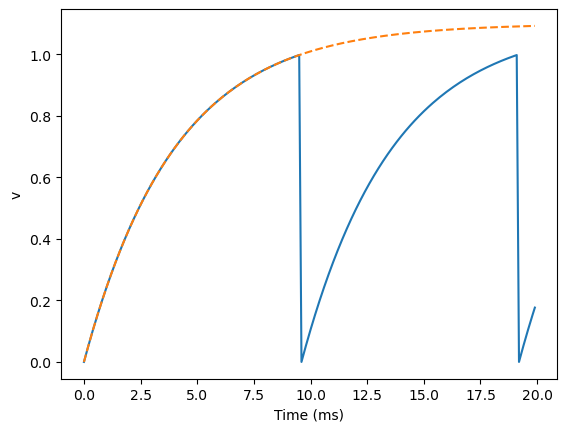

In [50]:
# plot(M1.t/ms, I/gamma(1-exp(-M1.t/tau)), 'C1--',label='Analytic')
# Sample first spikes

start_scope()

G1 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')

M1 = StateMonitor(G1, 'v', record=True)
S1 = SpikeMonitor(G1)

run(20*ms)

# solution to du/dt = (I/gamma - U)/tau is:
# I/gamma * (1 - exp(-t/tau))

plot(M1.t/ms, M1.v[0], label='Neuron 1')
plot(M1.t/ms, (I/gamma)*(1-exp(-M1.t/tau)), 'C1--',label='Analytic')
xlabel('Time (ms)')
ylabel('v');

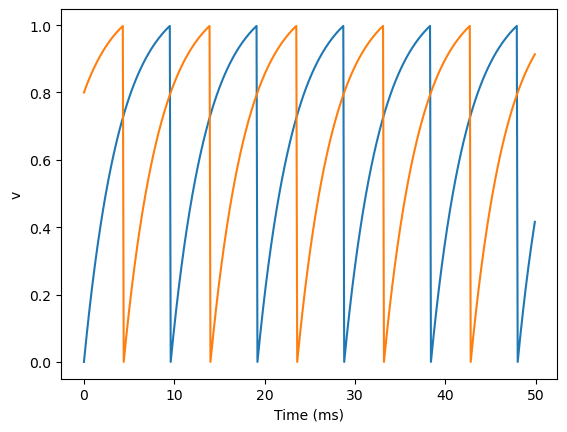

In [6]:
# Unconnected

start_scope()

G1 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')
G2 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')

G2.v = [0.8]

# S1 = Synapses(G1, G2, on_pre='v_post += 0.2')
# S2 = Synapses(G2, G1, on_pre='v_post += 0.2')

# S1.connect()
# S2.connect()

M1 = StateMonitor(G1, 'v', record=True)
M2 = StateMonitor(G2, 'v', record=True)
Sp1 = SpikeMonitor(G1)
Sp2 = SpikeMonitor(G2)

run(50*ms)

plot(M1.t/ms, M1.v[0], label='Neuron 1')
plot(M2.t/ms, M2.v[0], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v');

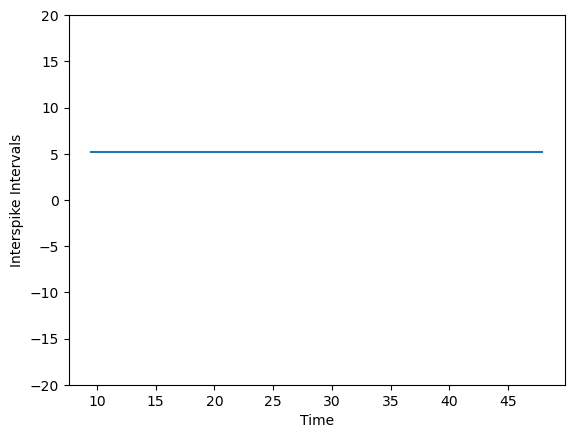

In [7]:
# Plotting phase separation between the two neurons over time

spikes = min(len(Sp2.t[:]), len(Sp1.t[:]))
Vals = Sp1.t[:spikes] - Sp2.t[:spikes]

plot(Sp1.t/ms, Vals/ms)
xlabel('Time')
ylabel('Interspike Intervals')
ylim(-20, 20);

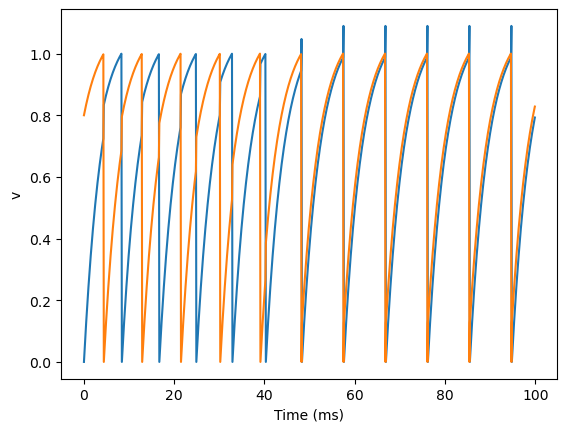

In [42]:
# Now with excitatory connections

start_scope()

G1 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')
G2 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')

G2.v = [0.8]

S1 = Synapses(G1, G2, on_pre='v_post += 0.1')
S2 = Synapses(G2, G1, on_pre='v_post += 0.1')

S1.connect()
S2.connect()

M1 = StateMonitor(G1, 'v', record=True)
M2 = StateMonitor(G2, 'v', record=True)
Sp1 = SpikeMonitor(G1)
Sp2 = SpikeMonitor(G2)

run(100*ms)

plot(M1.t/ms, M1.v[0], label='Neuron 1')
plot(M2.t/ms, M2.v[0], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v');

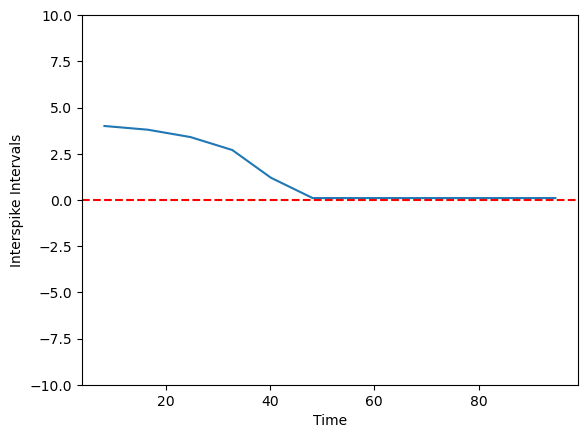

In [43]:
# plotting separations again

spikes = min(len(Sp2.t[:]), len(Sp1.t[:]))
Vals = Sp1.t[:spikes] - Sp2.t[:spikes]

plot(Sp1.t/ms, Vals/ms)
plt.axhline(y = 0, color = 'r', linestyle = '--')
xlabel('Time')
ylabel('Interspike Intervals')
ylim(-10, 10);

In [10]:
# Analytic solution of eqs2 that we're using: U = (I/gamma)*(1-exp(-M1.t/tau))
# function for this (computes analytic U for given value of t (phi)) => U_forward
# === can i make brian compute this? ===
# need to make a function that gives us the inverse, that is :
# we know U at time point t_-, we update it with an excitatory U(t_-) + e, we need to find the 'timepoint at which U' equals this update.
# i.e. U^-1(U(t_-) + e)
# on_pre='v_post = U_forward(min(U_inverse(v_post + e)), 1))'
# where U_inverse computes the time for U(t_-) + e and returns that time point. 
# inverse of a*(1 - e^(-bx)) is given by:  (1/b) * ln(1/(1 - x/a))
# inverse of (I/gamma)*(1 - e^(-1/tau * t)) will be (tau) * ln(1/(1 - gamma*t/I))

In [54]:
print(U_inverse(M1.v[0]))

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1
 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9
 9.  9.1 9.2 9.3 9.4 9.5 0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1
 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9
 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7
 4.8 4.9 5.  5.1 5.2 5.3 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5
 6.6 6.7 6.8 6.9 7.  7.1 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3
 8.4 8.5 8.6 8.7 8.8 8.9 9.  9.1 9.2 9.3 9.4 9.5 0.  0.1 0.2 0.3 0.4 0.5
 0.6 0.7] ms


In [114]:
def U_inverse(v):
        inv = tau * log(1/(1 - gamma*v/I))
        return inv

In [115]:
def U_forward(phi):
        forw = (I/gamma)*(1-exp(-phi/tau))
        return forw

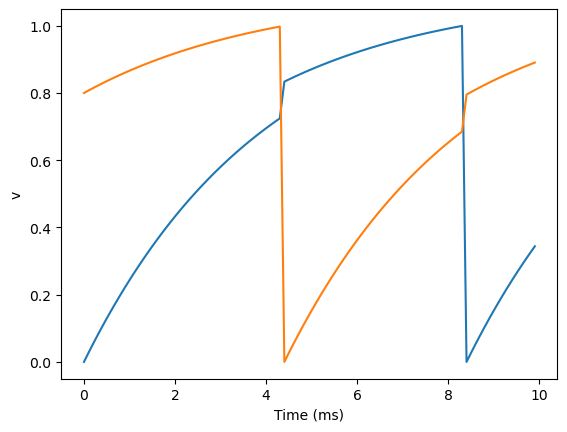

In [131]:
# Now with excitatory connections, according to update rule

start_scope()

exc = 0.1

# (i/g)*(1-exp(-(tp * log(1/(1 - g*(v_post + exc)/i)))/tp))

G1 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')
G2 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')

G2.v = [0.8]

S1 = Synapses(G1, G2, on_pre='v_post = out * (1-exp(-(tp * log(1/(1 - g*(v_post + exc)/curr)))/tp))')
S2 = Synapses(G2, G1, on_pre='v_post = out * (1-exp(-(tp * log(1/(1 - g*(v_post + exc)/curr)))/tp))')

S1.connect()
S2.connect()

M1 = StateMonitor(G1, 'v', record=True)
M2 = StateMonitor(G2, 'v', record=True)
Sp1 = SpikeMonitor(G1)
Sp2 = SpikeMonitor(G2)

run(10*ms)

plot(M1.t/ms, M1.v[0], label='Neuron 1')
plot(M2.t/ms, M2.v[0], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v');

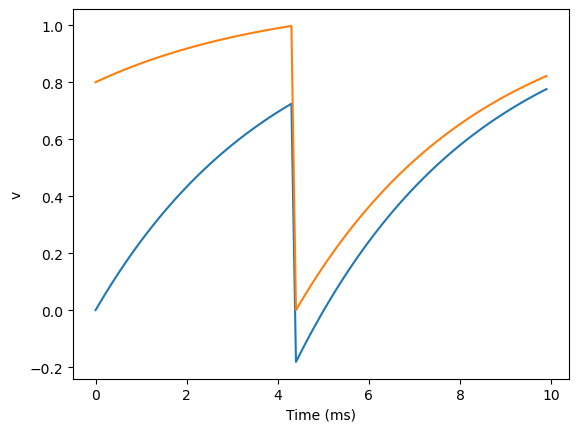

In [111]:
# Now with excitatory connections, according to update rule

start_scope()

exc = 0.1

G1 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')
G2 = NeuronGroup(1, eqs2, threshold='v>1', reset='v = 0', method='exact')

G2.v = [0.8]

S1 = Synapses(G1, G2, on_pre='v_post = log(g*(v_post + exc))')
S2 = Synapses(G2, G1, on_pre='v_post = log(g*(v_post + exc))')

S1.connect()
S2.connect()

M1 = StateMonitor(G1, 'v', record=True)
M2 = StateMonitor(G2, 'v', record=True)
Sp1 = SpikeMonitor(G1)
Sp2 = SpikeMonitor(G2)

run(10*ms)

plot(M1.t/ms, M1.v[0], label='Neuron 1')
plot(M2.t/ms, M2.v[0], label='Neuron 2')
xlabel('Time (ms)')
ylabel('v');

In [ ]:
# plotting separations again

spikes = min(len(Sp2.t[:]), len(Sp1.t[:]))
Vals = Sp1.t[:spikes] - Sp2.t[:spikes]

plot(Sp1.t/ms, Vals/ms)
plt.axhline(y = 0, color = 'r', linestyle = '--')
xlabel('Time')
ylabel('Interspike Intervals')
ylim(-10, 10);